# Movie Recommender System
----

A recommender system is a subclass of information filtering system that provides suggestions for items that are most pertinent to a particular user. Recommender systems are used in a variety of areas, with commonly recognised examples taking the form of playlist generators for video and music services, product recommenders for online stores, or content recommenders for social media platforms and open web content recommenders.

## Collaborative Filtering
---
Collaborative filtering is based on the assumption that people who agreed in the past will agree in the future, and that they will like similar kinds of items as they liked in the past. The system generates recommendations using only information about rating profiles for different users or items. By locating peer users/items with a rating history similar to the current user or item, they generate recommendations using this neighborhood. We will build collaborative filtering systems using KNN, SVD, Deep Learning to recommend more relevant movies to users based on ratings. 

## Modeling Techniques: 
---

- K Nearest Neighbour (KNN)
- Singular Value Decomposition (SVD)
- Deep Recommender System

## Data Sets
- MovieLens Datasets (https://grouplens.org/datasets/movielens/latest/)


In [1]:
# import module
import os
import time
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise import SVD
from surprise import accuracy
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda

%matplotlib inline

# 1. Load Data

In [2]:
# read movies
movies = pd.read_csv('movies.csv')
print(movies.shape)
print(movies.isnull().sum())
movies.head()

(62423, 3)
movieId    0
title      0
genres     0
dtype: int64


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# read ratings
ratings = pd.read_csv('ratings.csv')
print(ratings.shape)
print(ratings.isnull().sum())
ratings.head()

(25000095, 4)
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [4]:
num_users = len(ratings.userId.unique())
num_items = len(ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 162541 unique users and 59047 unique movies in this data set


# 2. Data Preparation

### Movie Publish Years

- If publishing year is present, remove the brackets and keep integer representation of the year
- Else, put 9999 as the year — an obvious indicator that year is missing

In [5]:
years = []

for title in movies['title']:
    year_subset = title[-5:-1]
    try: years.append(int(year_subset))
    except: years.append(9999)
        
movies['moviePubYear'] = years
print(len(movies[movies['moviePubYear'] == 9999]))

562


In [6]:
movies.head()

,movieId,title,genres,moviePubYear
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


### Movie genre

- Split the string on the pipe (|) character
- Create a new entry for each genre

In [7]:
genre_df = pd.DataFrame(movies['genres'].str.split('|').tolist(), index=movies['movieId']).stack()
genre_df = genre_df.reset_index([0, 'movieId'])
genre_df.columns = ['movieId', 'Genre']

In [8]:
genre_df.head()

,movieId,Genre
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


# 3. Exploratory Data Analysis

## Frequency of ratings

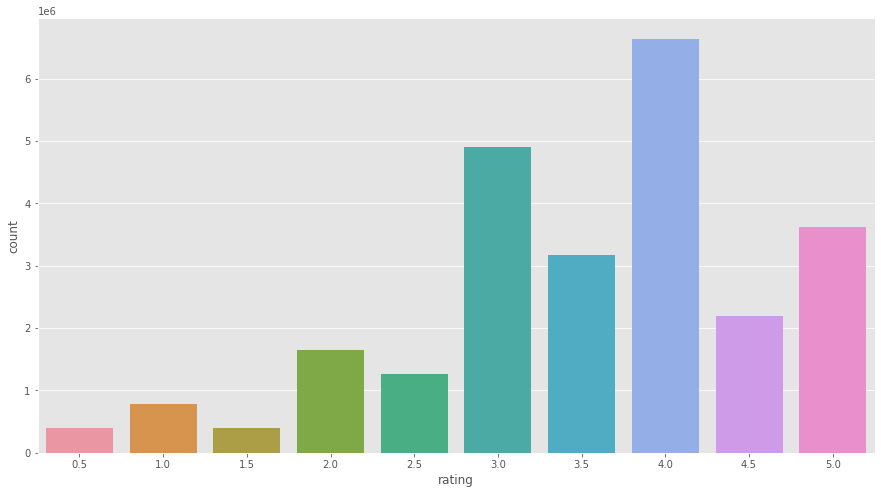

In [9]:
sns.countplot(data=ratings, x='rating')
plt.gcf().set_size_inches(15, 8)
plt.show()

## Frequency of release years

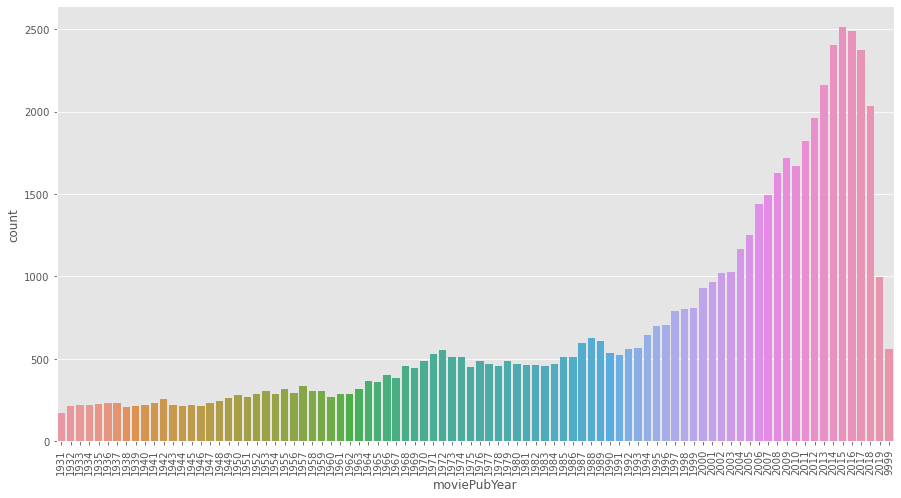

In [10]:
sns.countplot(data=movies[movies['moviePubYear']>1930], x='moviePubYear')
plt.gcf().set_size_inches(15, 8)
plt.xticks(rotation = 90)
plt.show()

## Frequency of Genre

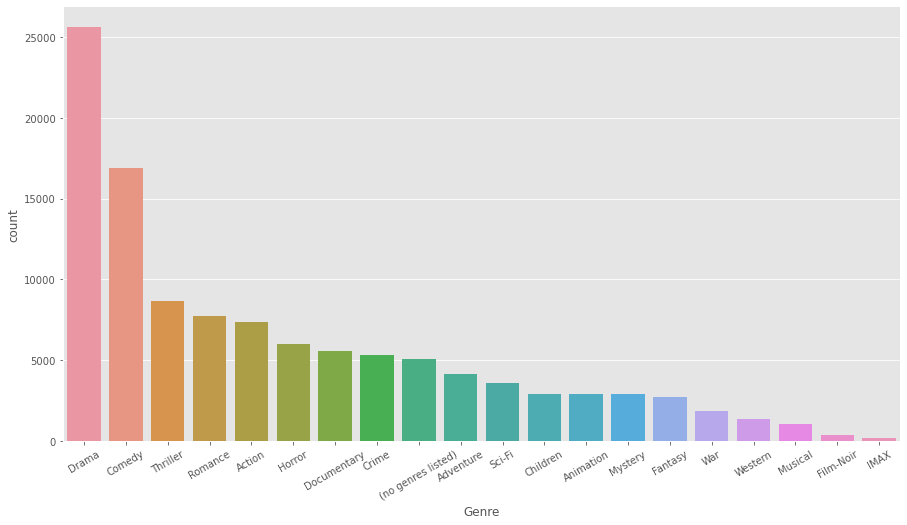

In [11]:
sns.countplot(data=genre_df, x='Genre', order = genre_df['Genre'].value_counts().index)
plt.gcf().set_size_inches(15, 8)
plt.xticks(rotation = 30)
plt.show()

## Ratings by Genre and Frequency

In [12]:
rating_agg = ratings.groupby('movieId').agg({'rating':['mean', 'count']})
rating_agg.columns = ['rating_mean', 'rating_count']
rating_agg.reset_index(inplace=True)
rating_agg.head()

,movieId,rating_mean,rating_count
0,1,3.893708,57309
1,2,3.251527,24228
2,3,3.142028,11804
3,4,2.853547,2523
4,5,3.058434,11714


In [13]:
rating_genre = genre_df.merge(rating_agg[['movieId', 'rating_mean']], how='inner', on='movieId')
rating_genre.groupby('Genre')['rating_mean'].mean().sort_values(ascending=False)

Genre
Documentary           3.382493
Film-Noir             3.318142
IMAX                  3.252121
War                   3.246515
Musical               3.200530
Drama                 3.178996
Romance               3.147095
Animation             3.101145
Crime                 3.092680
(no genres listed)    3.048613
Mystery               3.045787
Comedy                3.041878
Children              3.033051
Western               3.025755
Fantasy               3.020801
Adventure             3.011600
Thriller              2.944456
Action                2.926390
Sci-Fi                2.760530
Horror                2.650740
Name: rating_mean, dtype: float64

Documentary, Film-Noir, IMAX have higher average ratings, while Sci-Fi and Horror have lower average ratings.

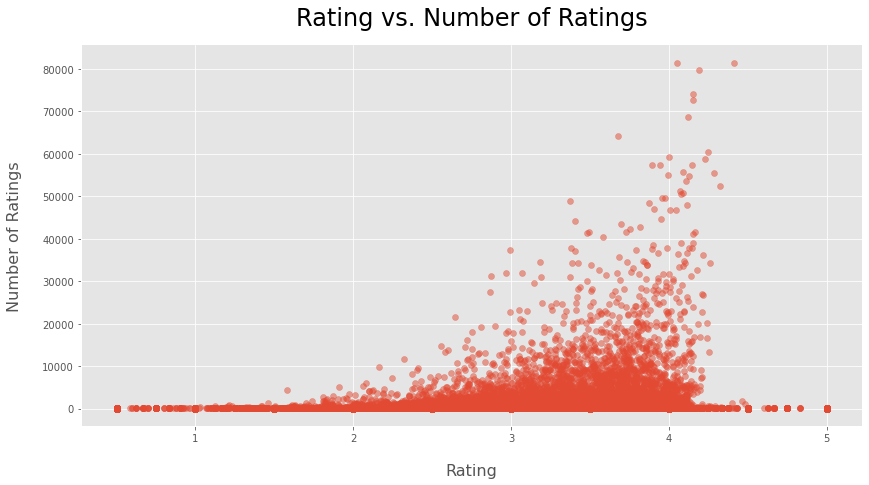

In [14]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Rating vs. Number of Ratings', fontsize=24, pad=20)
ax.set_xlabel('Rating', fontsize=16, labelpad=20)
ax.set_ylabel('Number of Ratings', fontsize=16, labelpad=20)

plt.scatter(rating_agg['rating_mean'], rating_agg['rating_count'], alpha=0.5)

We can see that many movies don't have many ratings but the scatter plot shows a little bit of an upward pattern. This is because good and popular movies are watched by many users and they are more likely to give higher ratings.

## Data Filtering

Movie ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users. Large number of less known movies don’t have ratings at all.

In [15]:
pd.DataFrame(rating_agg['rating_count'].sort_values(ascending=False))

,rating_count
351,81491
314,81482
292,79672
585,74127
2480,72674
...,...
41343,1
41350,1
41354,1
41355,1


Text(0, 0.5, 'number of ratings')

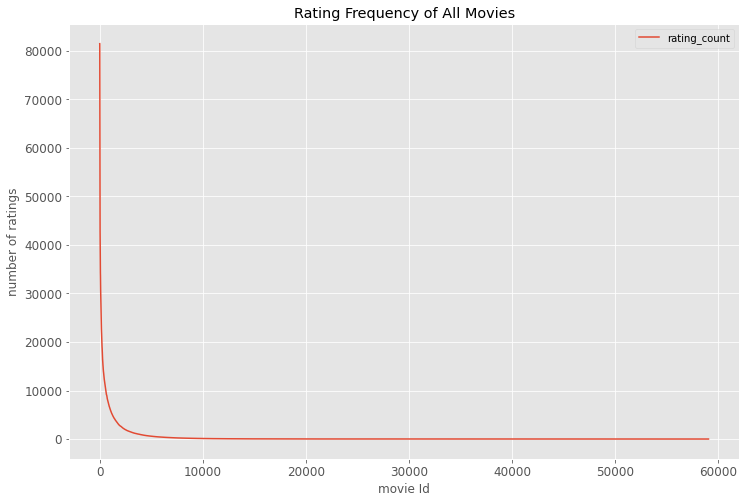

In [16]:
# plot rating frequency of all movies
ax = pd.DataFrame(rating_agg['rating_count']) \
    .sort_values('rating_count', ascending=False) \
    .reset_index(drop=True) \
    .plot(figsize=(12, 8),title='Rating Frequency of All Movies',fontsize=12)
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

In [17]:
rating_agg['rating_count'].quantile(np.arange(1, 0.6, -0.05))

1.00    81491.0
0.95     1503.4
0.90      413.0
0.85      152.0
0.80       68.0
0.75       36.0
0.70       22.0
0.65       14.0
Name: rating_count, dtype: float64

We can see that the majority of movies were barely rated by users. The movies that have less number of ratings can make the pattern more noisy so dropping them can improve recommendation quality. 

In [18]:
# filter data
popularity_thres = 50
popular_movies = list(rating_agg[rating_agg['rating_count'] >= popularity_thres].index)
ratings_drop_movies = ratings[ratings['movieId'].isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies: ', ratings_drop_movies.shape)

shape of original ratings data:  (25000095, 4)
shape of ratings data after dropping both unpopular movies:  (17052105, 4)


After dropping around 80% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

In [19]:
# get number of ratings given by every user
users_cnt = pd.DataFrame(ratings_drop_movies.groupby('userId').size(), columns=['count'])
users_cnt.head()

,count
userId,
1,56
2,152
3,236
4,74
5,92


Text(0, 0.5, 'number of ratings')

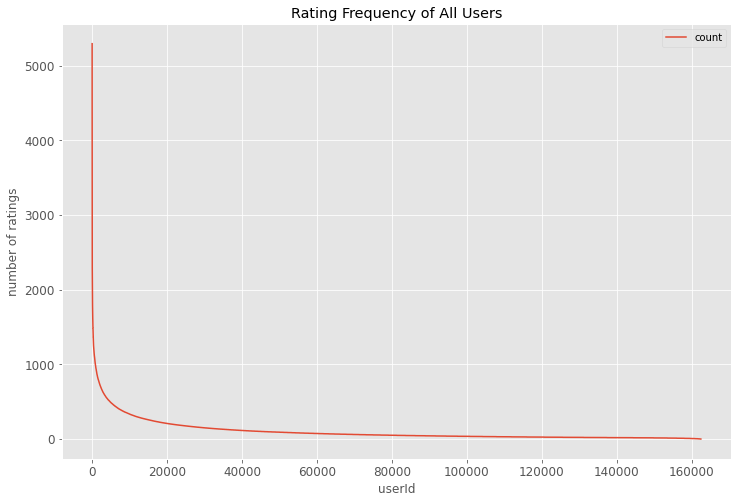

In [20]:
# plot rating frequency of all movies
ax = users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("userId")
ax.set_ylabel("number of ratings")

In [21]:
users_cnt['count'].quantile(np.arange(1, 0.2, -0.05))

1.00    5295.0
0.95     377.0
0.90     244.0
0.85     180.0
0.80     141.0
0.75     114.0
0.70      95.0
0.65      80.0
0.60      68.0
0.55      58.0
0.50      51.0
0.45      44.0
0.40      39.0
0.35      34.0
0.30      30.0
0.25      26.0
Name: count, dtype: float64

We will remove the users who have rated less than 30 times.  

In [22]:
# filter data
ratings_thres = 60
active_users = list(users_cnt[users_cnt['count'] >= ratings_thres].index)
ratings_drop_users = ratings_drop_movies[ratings_drop_movies['userId'].isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular books: ', ratings_drop_users.shape)

shape of original ratings data:  (25000095, 4)
shape of ratings data after dropping both unpopular books:  (14323309, 4)


In [23]:
len(ratings_drop_users['userId'].unique())

72134

In [24]:
num_movie = len(ratings_drop_users['movieId'].unique())
num_movie

7063

# 4. Recommender Models

## Data Split

In [25]:
train_df ,test_df = train_test_split(ratings_drop_users, test_size=0.3, random_state=42)
train_df.shape, test_df.shape

((10026316, 4), (4296993, 4))

## Sparse Matrix
If most of the elements of the matrix have 0 value, it is called a sparse matrix. The two major benefits of using sparse matrix instead of a simple matrix are:

- Storage: There are lesser non-zero elements than zeros and thus lesser memory can be used to store only those elements.
- Computing time: Computing time can be saved by logically designing a data structure traversing only non-zero elements.

In [26]:
# creating sparse matrix representation our dataframes
test_sparse_matrix = sparse.csr_matrix((test_df['rating'].values, (test_df['userId'].values,
                                               test_df['movieId'].values)))

train_sparse_matrix = sparse.csr_matrix((train_df['rating'].values, (train_df['userId'].values,
                                               train_df['movieId'].values)))

In [27]:
def check_sparsity(sparse_matrix):
    '''returns sparisty of matrix'''
    us,mv = sparse_matrix.shape
    elem = sparse_matrix.count_nonzero()
    sparsity = np.round((1-(elem/(us*mv))) * 100,4)
    return sparsity

In [28]:
# checking sparsity of train and test matrix
print("Sparsity of Train matrix : {} % | Sparsity of Test Matrix : {} %".format(check_sparsity(train_sparse_matrix),check_sparsity(test_sparse_matrix)))

Sparsity of Train matrix : 99.8942 % | Sparsity of Test Matrix : 99.9547 %


In [29]:
reader = Reader(rating_scale=(0,5))
# create the traindata from the dataframe...
train_data = Dataset.load_from_df(train_df[['userId','movieId','rating']], reader)
# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 
testset = list(zip(test_df['userId'].values, test_df['movieId'].values, test_df['rating'].values))

## K Nearest Neighbour (KNN)

We will use KNN with the option "user_based: False" to use item-based similarity, so that we are predicting the unknown ratings of item-based on similar items with known ratings. Cosine similarity is preferred instead of Euclidean distance, because it suffers less when the dataset is high in dimensionality.

In [30]:
# KNN Recommender
similarity = {
    "name": "cosine",
    "user_based": False,  # item-based similarity
}
algo_KNN = KNNWithMeans(sim_options = similarity)

def top_recommendations_KNN(userId, top_N):
    algo_KNN.fit(trainset)
    test_output = algo_KNN.test(testset)
    test_df = pd.DataFrame(test_output)
    print(test_df.head())
    print("RMSE -","algo_KNN", accuracy.rmse(test_output, verbose=False))
    print("MAE -", "algo_KNN", accuracy.mae(test_output, verbose=False))
    print("MSE -", "algo_KNN", accuracy.mse(test_output, verbose=False))
    
    ## Remove the movies already watched by the user
    movies_watched_by_user = ratings_drop_users[ratings_drop_users.userId == userId]
    movies_not_watched = movies[~movies["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
    
    ## KNN predictions
    pred_list = []
    for movieId in list(movies_not_watched):
        rating = algo_KNN.predict(userId, movieId).est
        pred_list.append([userId, movieId, rating])
    pred_df = pd.DataFrame(pred_list, columns = ['userId', 'movieId', 'rating'])

    recommended_movie = pd.merge(pred_df, movies, how='left', left_on='movieId', right_on='movieId')
    sorted_df = recommended_movie.groupby(('userId'), as_index = False).apply(lambda x: x.sort_values(['rating'], ascending = False)).reset_index(drop=True)
    top_recommended_movies = sorted_df.groupby('userId').head(top_N)
    
    print("Showing recommendations for user: {}".format(userId))
    print("====" * 9)
    print("Movies with high ratings from user")
    print("----" * 8)
    top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(5).movieId.values)
    movies_rows = movies[movies["movieId"].isin(top_movies_user)]
    for row in movies_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 8)
    print("Top 10 movie recommendations")
    print("----" * 8)
    for row in top_recommended_movies.itertuples():
        print(row.title, ":", row.genres)    

In [31]:
## KNN predictions
top_recommendations_KNN(2,10)

Computing the cosine similarity matrix...
Done computing similarity matrix.
      uid   iid  r_ui       est                                    details
0  116413  2284   4.0  3.673640  {'actual_k': 40, 'was_impossible': False}
1   79407   235   5.0  3.758159  {'actual_k': 40, 'was_impossible': False}
2   68322  4034   4.0  4.018046  {'actual_k': 40, 'was_impossible': False}
3    5017   357   3.0  3.262016  {'actual_k': 40, 'was_impossible': False}
4   17302  1625   3.0  3.405520  {'actual_k': 40, 'was_impossible': False}
RMSE - algo_KNN 0.8205367585820917
MAE - algo_KNN 0.6248171744557052
MSE - algo_KNN 0.673280572184406
Showing recommendations for user: 2
Movies with high ratings from user
--------------------------------
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Indiana Jones and the Last Crusade (1989) : Action|Ad

## Singular Value Decomposition (SVM)

Singular Value Decomposition is a matrix factorization technique that decomposes the user-item interaction matrix into the product of two lower dimensionality rectangular matrices, and then extracts the latent features from highest importance to lowest. 

In [32]:
# SVD Recommender
algo_SVD = SVD()

def top_recommendations_SVD(userId, top_N):
    algo_SVD.fit(trainset)
    test_output = algo_SVD.test(testset)
    test_df = pd.DataFrame(test_output)
    print(test_df.head())
    print("RMSE -","algo_SVD", accuracy.rmse(test_output, verbose=False))
    print("MAE -", "algo_SVD", accuracy.mae(test_output, verbose=False))
    print("MSE -", "algo_SVD", accuracy.mse(test_output, verbose=False))
    
    ## Remove the movies already watched by the user
    movies_watched_by_user = ratings_drop_users[ratings_drop_users.userId == userId]
    movies_not_watched = movies[~movies["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
    
    ## SVD predictions
    pred_list = []
    for movieId in list(movies_not_watched):
        rating = algo_SVD.predict(userId, movieId).est
        pred_list.append([userId, movieId, rating])
    pred_df = pd.DataFrame(pred_list, columns = ['userId', 'movieId', 'rating'])

    recommended_movie = pd.merge(pred_df, movies, how='left', left_on='movieId', right_on='movieId')
    sorted_df = recommended_movie.groupby(('userId'), as_index = False).apply(lambda x: x.sort_values(['rating'], ascending = False)).reset_index(drop=True)
    top_recommended_movies = sorted_df.groupby('userId').head(top_N)

    print("Showing recommendations for user: {}".format(userId))
    print("====" * 9)
    print("Movies with high ratings from user")
    print("----" * 8)
    top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(5).movieId.values)
    movies_rows = movies[movies["movieId"].isin(top_movies_user)]
    for row in movies_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 8)
    print("Top 10 movie recommendations")
    print("----" * 8)
    for row in top_recommended_movies.itertuples():
        print(row.title, ":", row.genres)    

In [34]:
## SVD predictions
top_recommendations_SVD(2,10)

      uid   iid  r_ui       est                    details
0  116413  2284   4.0  3.377319  {'was_impossible': False}
1   79407   235   5.0  3.923424  {'was_impossible': False}
2   68322  4034   4.0  4.130748  {'was_impossible': False}
3    5017   357   3.0  3.316386  {'was_impossible': False}
4   17302  1625   3.0  3.397387  {'was_impossible': False}
RMSE - algo_SVD 0.7762712248609028
MAE - algo_SVD 0.5921293117644975
MSE - algo_SVD 0.6025970145470463
Showing recommendations for user: 2
Movies with high ratings from user
--------------------------------
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Indiana Jones and the Last Crusade (1989) : Action|Adventure
Hoosiers (a.k.a. Best Shot) (1986) : Drama|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Wallace & Gromit:

## Deep Recommender System

An embedding is a low-dimensional space that captures the relationship of vectors from a higher dimensional space. The inputs to the model are the one-hot encoded user and item vectors for userId and movieId. Then, the user input vector and item input vector are fed to the user embedding and item embedding respectively, which results in a smaller, denser user and item vectors.

The embedded user and item vectors are concatenated before passing through a series of fully connected layers, which maps the concatenated embeddings into a prediction vector as output.

In [35]:
# encode the users
user_enc = LabelEncoder()
ratings_drop_users['user'] = user_enc.fit_transform(ratings_drop_users['userId'].values)
n_users = ratings_drop_users['user'].nunique()
user_enc_mapping = dict(zip(user_enc.classes_, user_enc.transform(user_enc.classes_)))

# encode the movies
item_enc = LabelEncoder()
ratings_drop_users['movie'] = item_enc.fit_transform(ratings_drop_users['movieId'].values)
n_movies = ratings_drop_users['movie'].nunique()
item_enc_mapping = dict(zip(item_enc.classes_, item_enc.transform(item_enc.classes_)))

ratings_drop_users['rating'] = ratings_drop_users['rating'].values.astype(np.float32)

# stats
min_rating = min(ratings_drop_users['rating'])
max_rating = max(ratings_drop_users['rating'])

print(n_users, n_movies, min_rating, max_rating)

72134 7063 0.5 5.0


In [36]:
X = ratings_drop_users[['user', 'movie']].values
y = ratings_drop_users['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape # looks good!

((10026316, 2), (4296993, 2), (10026316,), (4296993,))

In [37]:
X_train

array([[ 3159,  1424],
       [58767,  1992],
       [43862,   158],
       ...,
       [50550,  2911],
       [32772,  5961],
       [32151,  1144]], dtype=int64)

### Formatting as Arrays
The way we will build the Deep Recommender requires that the USER ID and the MOVIE ID both be fed as separate arrays. They will be pushed together as two entries in a list. Look below.

In [38]:
n_factors = 100
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# 0 is user, 1 is movie - need to use integers because we are slicing arrays

In [39]:
X_train_array

[array([ 3159, 58767, 43862, ..., 50550, 32772, 32151], dtype=int64),
 array([1424, 1992,  158, ..., 2911, 5961, 1144], dtype=int64)]

In [40]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       7213400     ['input_1[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 100)       706300      ['input_2[0][0]']                
                                                                                              

Epoch 1/200
4896/4896 [==============================] - 398s 81ms/step - loss: 0.8029 - val_loss: 0.6894
Epoch 2/200
4896/4896 [==============================] - 398s 81ms/step - loss: 0.6505 - val_loss: 0.6559
Epoch 3/200
4896/4896 [==============================] - 397s 81ms/step - loss: 0.5986 - val_loss: 0.6540
Epoch 4/200
4896/4896 [==============================] - 397s 81ms/step - loss: 0.5518 - val_loss: 0.6726
Epoch 5/200
4896/4896 [==============================] - 400s 82ms/step - loss: 0.5145 - val_loss: 0.7008
Epoch 6/200
4896/4896 [==============================] - 397s 81ms/step - loss: 0.4910 - val_loss: 0.7277
Epoch 7/200
4896/4896 [==============================] - 398s 81ms/step - loss: 0.4775 - val_loss: 0.7495
Epoch 8/200
4896/4896 [==============================] - 400s 82ms/step - loss: 0.4694 - val_loss: 0.7660
Epoch 9/200
4896/4896 [==============================] - 399s 81ms/step - loss: 0.4642 - val_loss: 0.7785
Epoch 10/200
4896/4896 [======================

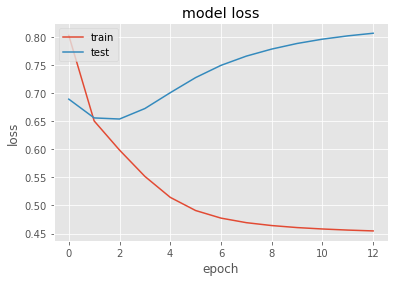

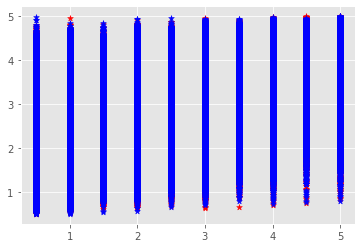

In [41]:
# early stop!
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,
                           patience=10,
                           restore_best_weights=True)

# fit the model
history = model.fit(x=X_train_array, y=y_train, batch_size=2048, epochs=200,
                    verbose=1, validation_data=(X_test_array, y_test),
                    callbacks=[early_stop])

# store results
train_preds = model.predict(X_train_array)
test_preds = model.predict(X_test_array)

# score/metrics
train_rmse = sqrt(mean_squared_error(y_train, train_preds))
test_rmse = sqrt(mean_squared_error(y_test, test_preds))
train_score = mean_absolute_error(y_train, train_preds)
test_score = mean_absolute_error(y_test, test_preds)

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Train MAE:', train_score)
print('Test MAE:', test_score)

# a nice plot
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# actual vs. pred
# train
plt.scatter(y_train,
          train_preds,
          marker = '*',
          color='red')
plt.scatter(y_test,
          test_preds,
          marker = '*',
          color='blue')
plt.show()

In [42]:
# Deep Recommender

def top_recommendations_DEEP(user_Id, top_N):
    movies_watched_by_user = ratings_drop_users[ratings_drop_users.userId == user_Id]
    movies_not_watched = movies[~movies["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
    movies_not_watched = list(set(movies_not_watched).intersection(set(item_enc_mapping.keys())))
    movies_not_watched = [[item_enc_mapping.get(x)] for x in movies_not_watched]
    
    user_encoder = item_enc_mapping.get(user_Id)
    user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    user_movie_array = [user_movie_array[:, 0], user_movie_array[:, 1]]
    
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[::-1]
    recommended_movie_ids = [item_enc_mapping.get(movies_not_watched[x][0]) for x in top_ratings_indices]
    recommended_movie_ids = list(filter(None,recommended_movie_ids))[:top_N]
    
    print("Showing recommendations for user: {}".format(user_Id))
    print("====" * 9)
    print("Movies with high ratings from user")
    print("----" * 8)
    top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(5).movieId.values)
    movies_rows = movies[movies["movieId"].isin(top_movies_user)]
    for row in movies_rows.itertuples():
        print(row.title, ":", row.genres)

    print("----" * 8)
    print("Top 10 movie recommendations")
    print("----" * 8)
    recommended_movies = movies[movies["movieId"].isin(recommended_movie_ids)]
    for row in recommended_movies.itertuples():
        print(row.title, ":", row.genres)

In [43]:
top_recommendations_DEEP(2,10)

Showing recommendations for user: 2
Movies with high ratings from user
--------------------------------
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Star Wars: Episode V - The Empire Strikes Back (1980) : Action|Adventure|Sci-Fi
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Indiana Jones and the Last Crusade (1989) : Action|Adventure
Hoosiers (a.k.a. Best Shot) (1986) : Drama|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Ladybird Ladybird (1994) : Drama
Legends of the Fall (1994) : Drama|Romance|War|Western
Executive Decision (1996) : Action|Adventure|Thriller
It's a Wonderful Life (1946) : Children|Drama|Fantasy|Romance
Tom Jones (1963) : Adventure|Comedy|Romance
Inheritors, The (Siebtelbauern, Die) (1998) : Drama|Mystery
Naked Man, The (1998) : Drama
River, The (1984) : Drama
They Might Be Giants (1971) : Comedy|Mystery|Romance
Happy Together (1989) : Drama|Romance


- Deep Recommender and Singular Vector Machine which use latent feature vectors perform better than K-Nearest Neighbors based on RMSE.
- The user '2' has given high ratings to Adventure, Action, and Romance and the three models also recommend those genres to the user. However, the movies recommended by the models are different from each other.
- It seems that we need to conduct A/B testings to decide which model recommends more relevant movies to users.